In [67]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
# sys.path.insert(1, 'C:/Users/chuck/OneDrive/Desktop/Honors/solarEL/solarel')
# from image_processor import split_module_to_cells
import time

# Load image

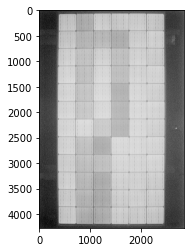

In [68]:
import os, random
image_dir = random.choice(os.listdir("module_images"))
img = cv2.imread(f"module_images/{image_dir}")
plt.imshow(img)

# Make PDF

In [75]:
from fpdf import FPDF

title = 'EL image report'


class PDF(FPDF):
    def header(self):
        # font
        self.set_font('Helvetica', 'B', 18)
        # Calculate width of title and position
        title_w = self.get_string_width(title) + 6
        doc_w = self.w
        self.set_x((doc_w - title_w) / 2)
        # Thickness of frame (border)
        self.set_line_width(1)
        # Title
        self.cell(title_w, 10, title, ln=1, align='C')
        # Line break
        self.ln(10)

    # Page footer
    def footer(self):
        # Set position of the footer
        self.set_y(-15)
        # set font
        self.set_font('helvetica', 'I', 8)
        # Set font color grey
        self.set_text_color(169,169,169)
        # Page number
        self.cell(0, 10, f'Page {self.page_no()}', align='C')

    # Adding chapter title to start of each chapter
    def chapter_title(self, ch_num, ch_title, link):
        # Set link location
        self.set_link(link)
        # set font
        self.set_font('Helvetica', '', 16)
        # background color
        chapter_title = f'Chapter {ch_num} : {ch_title}'
        self.cell(0, 5, chapter_title, ln=1)
        # line break
        self.ln()

    # Chapter content
    def chapter_body(self, name):
        # read text file
        with open(name, 'rb') as fh:
            txt = fh.read().decode('latin-1')
        # set font
        self.set_font('times', '', 12)
        # insert text
        self.multi_cell(0, 5, txt)
        # line break
        self.ln()
        # end each chapter
        self.set_font('times', 'I', 12)
        self.cell(0, 5, 'END OF CHAPTER')

    def print_chapter(self, ch_num, ch_title, name, link):
        self.add_page()
        self.chapter_title(ch_num, ch_title, link)
        self.chapter_body(name)

# Create a PDF object
pdf = PDF('P', 'mm', 'Letter')

# metadata
pdf.set_title(title)
pdf.set_author('UTAS - CSIRO')


# Set auto page break
pdf.set_auto_page_break(auto = True, margin = 15)

# Add Page
pdf.add_page()
pdf.image('report_images/CSIRO_Logo.png', x = 5, y = 5, w=20, h=20)
pdf.image('report_images/Utas_Logo.png', x = pdf.w-5-25, y = 5, h=20)

image 
pdf.image('module_images/1090605175SB1050496_IMG_8938.JPG', x = 20, y = 50, w = pdf.w-40)

pdf.output('pdf_4.pdf')

''

In [ ]:
import cv2
img = cv2.imread("report_images/CSIRO_Logo_raw.png", -1)
res = cv2.resize(img, (0,0), fx=0.2, fy=0.2, interpolation = cv2.INTER_AREA)
cv2.imwrite("report_images/CSIRO_Logo.png", res)

True